In [321]:
idx = 15

In [322]:
import sys
sys.path.append("..") 
sys.path.append("../..") 
import torch
from models.components.ldm.denoiser import UNetModel
import numpy as np
import torch.nn.functional as F
import json

import hydra
from LDM_conditional.DownscalingDataModule import DownscalingDataModule
from LDM_conditional.models.unet_module import DownscalingUnet
from LDM_conditional.models.ae_module import AutoencoderKL
from LDM_conditional.models.ldm_module import LatentDiffusion
from LDM_conditional.models.components.ldm.denoiser import DDIMSampler
from omegaconf import DictConfig

In [323]:
import seaborn as sns
sns.set() 
import matplotlib.pyplot as plt
import numpy as np

In [324]:
from models.unet_module import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.ldm_module import LatentDiffusion
from DownscalingDataModule import DownscalingDataModule

Dataloaders

In [325]:
# Define train and val input/target paths (update file paths as needed)
train_input_paths = {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_input_train_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_input_train_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_input_train_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_input_train_scaled.nc"
}
train_target_paths = {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_target_train_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_target_train_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_target_train_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_target_train_scaled.nc"
}
val_input_paths = {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_input_val_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_input_val_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_input_val_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_input_val_scaled.nc"
}
val_target_paths = {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_target_val_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_target_val_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_target_val_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_target_val_scaled.nc"
}

test_input_paths= {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_input_test_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_input_test_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_input_test_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_input_test_scaled.nc"
}

test_target_paths = {
    'precip': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_target_test_scaled.nc",
    'temp': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_target_test_scaled.nc",
    'temp_min': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_target_test_scaled.nc",
    'temp_max': "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_target_test_scaled.nc"
}


In [326]:
elevation_path = f'/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [327]:
dm = DownscalingDataModule(
    train_input=train_input_paths,
    train_target=train_target_paths,
    val_input=val_input_paths,
    val_target=val_target_paths,
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)
dm.setup()

# Get dataloaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [328]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [329]:
train_inputs, train_targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))
test_inputs, test_targets = next(iter(test_loader))

1. Plotting Unet pred for idex = idx

In [330]:
ckpt_unet = "trained_ckpts/10km/LDM_conditional.models.unet_module.DownscalingUnetLightning_checkpoint.ckpt"


In [331]:

model_UNet = DownscalingUnetLightning(
    in_ch=5,  # 4 vars + elevation
    out_ch=4,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp", "temp_min", "temp_max"]
)

In [332]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu")["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [333]:
with open("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/RhiresD_scaling_params.json", 'r') as f:
    pr_params = json.load(f)
with open("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TabsD_scaling_params.json", 'r') as f:
    temp_params = json.load(f)
with open("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TminD_scaling_params.json", 'r') as f:
    temp_min_params = json.load(f)
with open("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_10km/TmaxD_scaling_params.json", 'r') as f:
    temp_max_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']

In [334]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [335]:
UNet_model = model_UNet.to(device)

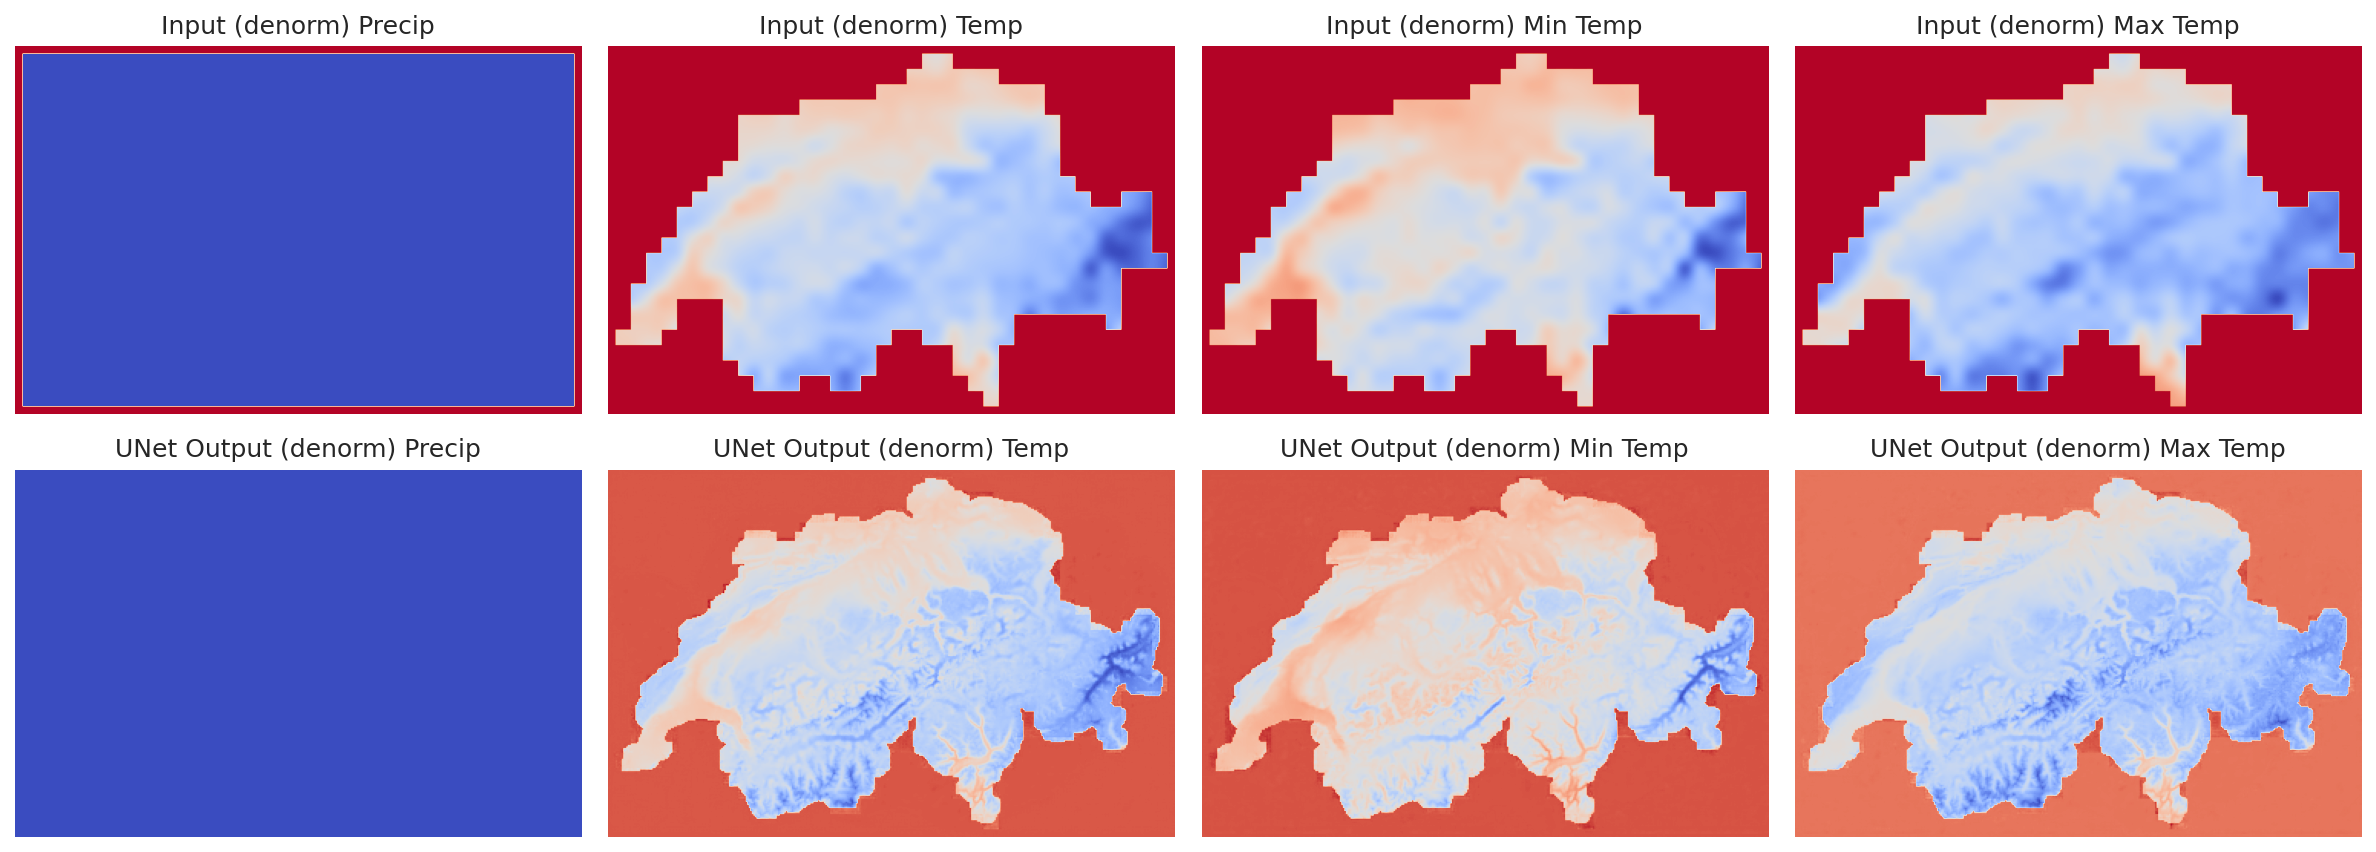

In [336]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)  # (1, 5, H, W)
    unet_pred = UNet_model(input_sample)                    # (1, 4, H, W)

input_np = input_sample[0, :4].cpu().numpy()    # (4, H, W)
unet_pred_np = unet_pred[0].cpu().numpy()       # (4, H, W)
channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]

#input_destd
input_denorm = np.empty_like(input_np)
for i, (var, params) in enumerate([
    ("precip", pr_params),
    ("temp", temp_params),
    ("temp_min", temp_min_params),
    ("temp_max", temp_max_params)
]):
    if var == "precip":
        input_denorm[i] = denorm_pr(input_np[i])
    else:
        input_denorm[i] = denorm_temp(input_np[i], params)

unet_pred_denorm = np.empty_like(unet_pred_np)
params_list = [pr_params, temp_params, temp_min_params, temp_max_params]
for i, (var, params) in enumerate([
    ("precip", pr_params),
    ("temp", temp_params),
    ("temp_min", temp_min_params),
    ("temp_max", temp_max_params)
]):
    if var == "precip":
        unet_pred_denorm[i] = denorm_pr(unet_pred_np[i])
    else:
        unet_pred_denorm[i] = denorm_temp(unet_pred_np[i], params)

fig, axes = plt.subplots(2, 4, figsize=(16, 6), dpi=150)
for j in range(4):
    axes[0, j].imshow(np.flipud(input_denorm[j]), cmap='coolwarm')
    axes[0, j].set_title(f"Input (denorm) {channel_names[j]}")
    axes[0, j].axis('off')
    axes[1, j].imshow(np.flipud(unet_pred_denorm[j]), cmap='coolwarm')
    axes[1, j].set_title(f"UNet Output (denorm) {channel_names[j]}")
    axes[1, j].axis('off')
plt.tight_layout()
plt.show()

#VAE encoding residuals 

In [337]:
encoder= SimpleConvEncoder(in_dim=4, levels=2,min_ch=16,ch_mult=4)
decoder = SimpleConvDecoder(in_dim=64, levels=2, min_ch=16, out_dim=4, ch_mult=4)

normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=4, norm_type=group, norm_kwargs={'num_groups': 1}


In [338]:
unet_regr= DownscalingUnetLightning(in_ch=5,
                                    out_ch=4,
                                    features=[64, 128, 256, 512],
                                    channel_names=["precip", "temp", "temp_min", "temp_max"])

In [339]:
unet_regr_ckpt = torch.load("trained_ckpts/10km/LDM_conditional.models.unet_module.DownscalingUnetLightning_checkpoint.ckpt",
                            map_location="cpu"
)["state_dict"]

In [340]:
unet_regr.load_state_dict(unet_regr_ckpt, strict=False) #Loading it second time for regression network inside VAE
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

Instantiating VAE

In [341]:
vae_model= AutoencoderKL(encoder=encoder, decoder=decoder, 
                         kl_weight=0.01,
                         ae_flag="residual",
                         unet_regr=unet_regr)

In [342]:
vae_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts/10km/LDM_conditional.models.ae_module.AutoencoderKL_checkpoint.ckpt",
    map_location="cpu"
)["state_dict"]
vae_model.load_state_dict(vae_ckpt, strict=False)
vae_model = vae_model.to(device)
vae_model.eval()

AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 4, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 16, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 4, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 16, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
      (2): ResBlock2D(
        (proj): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))


Loading LDM ckp

In [343]:
# Instantiate the context conditioner
from models.components.ldm.conditioner import AFNOConditionerNetCascade

conditioner = AFNOConditionerNetCascade(
    autoencoder=vae_model,
    embed_dim=[64, 128, 256, 256],
    analysis_depth=4,
    cascade_depth=4,
    context_ch=[64, 128, 256, 256]
)

normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=256, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 8}


In [344]:
# denoiser UNet
from models.components.ldm.denoiser.unet import UNetModel

denoiser = UNetModel(
    model_channels=64,
    in_channels=32,
    out_channels=32,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=[64, 128, 256, 256],
    channel_mult=[1, 2, 4, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=4
)



In [345]:
from models.ldm_module import LatentDiffusion

ldm = LatentDiffusion(
    denoiser=denoiser,
    autoencoder=vae_model,
    context_encoder=conditioner,
    timesteps=1000,
    parameterization="v",
    loss_type="l2"
)

# 5. Load the trained LDM checkpoint
ldm_ckpt = torch.load(
    "trained_ckpts/10km/LDM_checkpoint_V1_linear_schedule_250_steps.ckpt",
    map_location=device
)
ldm.load_state_dict(ldm_ckpt["state_dict"], strict=False)

# Set to eval mode and move to device
ldm = ldm.to(device)
ldm.eval()

LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

In [346]:
from models.components.ldm.denoiser.ddim import DDIMSampler

#UNet prediction and compute normalized residual
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)   # (1, 5, H, W)
    unet_pred = UNet_model(input_sample)                      # (1, 4, H, W)
    target_sample = test_targets[idx].unsqueeze(0).to(device) # (1, 4, H, W)
    residual = target_sample - unet_pred                      # (1, 4, H, W)

# Encode residual with VAE to get mean and logvar, then sample z
with torch.no_grad():
    # Try unpacking as a tuple
    mu, logvar = vae_model.encode(residual)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

In [347]:
# context using the conditioner
with torch.no_grad():
    # The conditioner expects a list of tuples: [(coarse_pred, None)]
    context = conditioner([(unet_pred, None)])  # List of context tensors per scale

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])


In [348]:
# Denoise using DDIMSampler, conditioned on context
sampler = DDIMSampler(ldm, device=device)
latent_shape = z.shape[1:]  # (latent_ch, H, W)
S =500 # Number of DDIM steps (as in your config)

conditioning = [(unet_pred, None)]
sampled_latent, _ = sampler.sample(
    S=S,
    batch_size=1,
    shape=latent_shape,
    conditioning=conditioning,
    eta=0.0,
    verbose=True,

)

with torch.no_grad():
    generated_residual = vae_model.decode(sampled_latent)

    # Crop generated_residual to match unet_pred shape if needed
    if generated_residual.shape != unet_pred.shape:
        # Only crop spatial dims (assume NCHW)
        _, _, h1, w1 = unet_pred.shape
        _, _, h2, w2 = generated_residual.shape
        crop_h = min(h1, h2)
        crop_w = min(w1, w2)
        # Center crop generated_residual to match unet_pred
        start_h = (h2 - crop_h) // 2
        start_w = (w2 - crop_w) // 2
        generated_residual = generated_residual[:, :, start_h:start_h+crop_h, start_w:start_w+crop_w]
        # If unet_pred is larger, crop it too
        if h1 != crop_h or w1 != crop_w:
            start_h_u = (h1 - crop_h) // 2
            start_w_u = (w1 - crop_w) // 2
            unet_pred = unet_pred[:, :, start_h_u:start_h_u+crop_h, start_w_u:start_w_u+crop_w]

final_pred = unet_pred + generated_residual


Selected timesteps for ddim sampler: [  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215
 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251
 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283 285 287
 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323
 325 327 329 331 333 335 337 339 341 343 345 347 349 351 353 355 357 359
 361 363 365 367 369 371 373 375 377 379 381 383 385 387 389 391 393 395
 397 399 401 403 405 407 409 411 413 415 417 419 421 423 425 427 429 431
 433 435 437 439 441 443 445 447 449 451 453 455 457 459 461 463 465 467
 469 471 473 4

DDIM Sampler:   1%|          | 3/500 [00:00<00:21, 22.68it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   1%|          | 6/500 [00:00<00:21, 22.84it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:   2%|▏         | 9/500 [00:00<00:21, 22.90it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   2%|▏         | 12/500 [00:00<00:21, 22.98it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:   4%|▎         | 18/500 [00:00<00:20, 23.03it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   4%|▍         | 21/500 [00:00<00:20, 23.01it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:   5%|▌         | 27/500 [00:01<00:20, 22.78it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:   6%|▌         | 30/500 [00:01<00:20, 22.80it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:   7%|▋         | 36/500 [00:01<00:20, 22.93it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:   8%|▊         | 39/500 [00:01<00:20, 22.91it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:   8%|▊         | 42/500 [00:01<00:20, 22.89it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:   9%|▉         | 45/500 [00:01<00:19, 22.94it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  10%|▉         | 48/500 [00:02<00:19, 23.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  10%|█         | 51/500 [00:02<00:19, 23.07it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  11%|█         | 54/500 [00:02<00:19, 23.13it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  12%|█▏        | 60/500 [00:02<00:18, 23.28it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  13%|█▎        | 63/500 [00:02<00:18, 23.21it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  14%|█▍        | 69/500 [00:02<00:18, 23.24it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  14%|█▍        | 72/500 [00:03<00:18, 23.27it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  15%|█▌        | 75/500 [00:03<00:18, 23.33it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:  16%|█▌        | 78/500 [00:03<00:18, 23.42it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  17%|█▋        | 84/500 [00:03<00:17, 23.29it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  17%|█▋        | 87/500 [00:03<00:17, 23.21it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  19%|█▊        | 93/500 [00:04<00:17, 23.38it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  19%|█▉        | 96/500 [00:04<00:17, 23.37it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  20%|█▉        | 99/500 [00:04<00:17, 23.41it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])


DDIM Sampler:  20%|██        | 102/500 [00:04<00:16, 23.46it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  21%|██        | 105/500 [00:04<00:16, 23.43it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  22%|██▏       | 108/500 [00:04<00:16, 23.44it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  22%|██▏       | 111/500 [00:04<00:16, 23.41it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  23%|██▎       | 117/500 [00:05<00:16, 23.18it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  24%|██▍       | 120/500 [00:05<00:16, 23.17it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  25%|██▌       | 126/500 [00:05<00:16, 23.29it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  26%|██▌       | 129/500 [00:05<00:15, 23.26it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape afte

DDIM Sampler:  26%|██▋       | 132/500 [00:05<00:15, 23.30it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  27%|██▋       | 135/500 [00:05<00:15, 23.28it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  28%|██▊       | 141/500 [00:06<00:15, 23.37it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  29%|██▉       | 144/500 [00:06<00:15, 23.33it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  30%|███       | 150/500 [00:06<00:14, 23.41it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape afte

DDIM Sampler:  31%|███       | 153/500 [00:06<00:14, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  32%|███▏      | 159/500 [00:06<00:14, 23.33it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  32%|███▏      | 162/500 [00:06<00:14, 23.31it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  33%|███▎      | 165/500 [00:07<00:14, 23.38it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  34%|███▎      | 168/500 [00:07<00:14, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  35%|███▍      | 174/500 [00:07<00:13, 23.32it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  35%|███▌      | 177/500 [00:07<00:13, 23.29it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  37%|███▋      | 183/500 [00:07<00:13, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  37%|███▋      | 186/500 [00:08<00:13, 23.00it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  38%|███▊      | 189/500 [00:08<00:13, 22.98it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  38%|███▊      | 192/500 [00:08<00:13, 22.99it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  39%|███▉      | 195/500 [00:08<00:13, 22.09it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet for

DDIM Sampler:  40%|████      | 201/500 [00:08<00:13, 21.77it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  41%|████      | 204/500 [00:08<00:13, 22.17it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 1

DDIM Sampler:  42%|████▏     | 210/500 [00:09<00:12, 22.82it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  43%|████▎     | 213/500 [00:09<00:12, 22.95it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  43%|████▎     | 216/500 [00:09<00:12, 23.08it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  44%|████▍     | 219/500 [00:09<00:12, 23.15it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape afte

DDIM Sampler:  45%|████▌     | 225/500 [00:09<00:11, 23.09it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  46%|████▌     | 228/500 [00:09<00:11, 23.10it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  47%|████▋     | 234/500 [00:10<00:11, 23.18it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  47%|████▋     | 237/500 [00:10<00:11, 23.22it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  48%|████▊     | 240/500 [00:10<00:11, 23.30it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  49%|████▊     | 243/500 [00:10<00:10, 23.41it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  49%|████▉     | 246/500 [00:10<00:10, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  50%|████▉     | 249/500 [00:10<00:10, 23.32it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  50%|█████     | 252/500 [00:10<00:10, 23.40it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  51%|█████     | 255/500 [00:11<00:10, 22.52it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  52%|█████▏    | 258/500 [00:11<00:10, 22.69it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  52%|█████▏    | 261/500 [00:11<00:10, 22.75it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
U

DDIM Sampler:  53%|█████▎    | 267/500 [00:11<00:10, 23.11it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  54%|█████▍    | 270/500 [00:11<00:09, 23.14it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  55%|█████▍    | 273/500 [00:11<00:09, 23.23it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  55%|█████▌    | 276/500 [00:11<00:09, 23.31it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  56%|█████▌    | 279/500 [00:12<00:09, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  56%|█████▋    | 282/500 [00:12<00:09, 23.39it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  57%|█████▋    | 285/500 [00:12<00:09, 23.36it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  58%|█████▊    | 291/500 [00:12<00:08, 23.31it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  59%|█████▉    | 294/500 [00:12<00:08, 23.26it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  60%|██████    | 300/500 [00:12<00:08, 23.30it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  61%|██████    | 303/500 [00:13<00:08, 23.34it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  61%|██████    | 306/500 [00:13<00:08, 23.34it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape afte

DDIM Sampler:  62%|██████▏   | 309/500 [00:13<00:08, 23.37it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  62%|██████▏   | 312/500 [00:13<00:08, 23.33it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  63%|██████▎   | 315/500 [00:13<00:07, 23.26it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  64%|██████▎   | 318/500 [00:13<00:07, 23.21it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  65%|██████▍   | 324/500 [00:14<00:07, 23.37it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  65%|██████▌   | 327/500 [00:14<00:07, 23.31it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  66%|██████▌   | 330/500 [00:14<00:07, 23.38it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  67%|██████▋   | 333/500 [00:14<00:07, 23.40it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  67%|██████▋   | 336/500 [00:14<00:07, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  68%|██████▊   | 339/500 [00:14<00:06, 23.32it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  68%|██████▊   | 342/500 [00:14<00:06, 23.32it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  70%|██████▉   | 348/500 [00:15<00:06, 23.35it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  70%|███████   | 351/500 [00:15<00:06, 23.27it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  71%|███████▏  | 357/500 [00:15<00:06, 23.43it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  72%|███████▏  | 360/500 [00:15<00:05, 23.44it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  73%|███████▎  | 363/500 [00:15<00:05, 23.48it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 3

DDIM Sampler:  73%|███████▎  | 366/500 [00:15<00:05, 23.49it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  74%|███████▍  | 372/500 [00:16<00:05, 23.48it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  75%|███████▌  | 375/500 [00:16<00:05, 23.48it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  76%|███████▌  | 381/500 [00:16<00:05, 23.50it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  77%|███████▋  | 384/500 [00:16<00:04, 23.47it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  77%|███████▋  | 387/500 [00:16<00:04, 23.51it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  78%|███████▊  | 390/500 [00:16<00:04, 23.53it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  79%|███████▊  | 393/500 [00:16<00:04, 23.47it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  79%|███████▉  | 396/500 [00:17<00:04, 23.49it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  80%|███████▉  | 399/500 [00:17<00:04, 23.55it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  81%|████████  | 405/500 [00:17<00:04, 23.61it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  82%|████████▏ | 408/500 [00:17<00:03, 23.55it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 1

DDIM Sampler:  83%|████████▎ | 414/500 [00:17<00:03, 23.58it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  83%|████████▎ | 417/500 [00:17<00:03, 23.56it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  84%|████████▍ | 420/500 [00:18<00:03, 23.58it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO 

DDIM Sampler:  85%|████████▍ | 423/500 [00:18<00:03, 23.59it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 3

DDIM Sampler:  86%|████████▌ | 429/500 [00:18<00:03, 23.59it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  86%|████████▋ | 432/500 [00:18<00:02, 23.52it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 1

DDIM Sampler:  88%|████████▊ | 438/500 [00:18<00:02, 23.48it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  88%|████████▊ | 441/500 [00:18<00:02, 23.31it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  89%|████████▉ | 444/500 [00:19<00:02, 23.31it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  89%|████████▉ | 447/500 [00:19<00:02, 23.29it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  91%|█████████ | 453/500 [00:19<00:02, 23.30it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  91%|█████████ | 456/500 [00:19<00:01, 23.29it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  92%|█████████▏| 462/500 [00:19<00:01, 23.45it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  93%|█████████▎| 465/500 [00:20<00:01, 23.47it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  94%|█████████▎| 468/500 [00:20<00:01, 23.46it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 

DDIM Sampler:  94%|█████████▍| 471/500 [00:20<00:01, 23.33it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler:  95%|█████████▍| 474/500 [00:20<00:01, 23.24it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

DDIM Sampler:  95%|█████████▌| 477/500 [00:20<00:00, 23.22it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  96%|█████████▌| 480/500 [00:20<00:00, 23.32it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y

DDIM Sampler:  97%|█████████▋| 486/500 [00:20<00:00, 23.55it/s]

AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Condit

DDIM Sampler:  98%|█████████▊| 489/500 [00:21<00:00, 23.71it/s]

AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60

DDIM Sampler:  98%|█████████▊| 492/500 [00:21<00:00, 23.70it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 1

DDIM Sampler:  99%|█████████▉| 495/500 [00:21<00:00, 23.74it/s]

AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 8, 12, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 8, 12, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 15, 23, 256])
AFNO y (after proj/interp) shape: torch.Size([1, 15, 23, 256])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1,

DDIM Sampler: 100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 64, 60, 92])
Conditioner cascade[1] shape after proj: torch.Size([1, 128, 30, 46])
Conditioner cascade[2] shape after proj: torch.Size([1, 256, 15, 23])
Conditioner cascade[3] shape after proj: torch.Size([1, 256, 7, 11])
UNet forward called with x shape: torch.Size([1, 32, 60, 92]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 64, 60, 92])
UNet forward context[1] shape: torch.Size([1, 128, 30, 46])
UNet forward context[2] shape: torch.Size([1, 256, 15, 23])
UNet forward context[3] shape: torch.Size([1, 256, 7, 11])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 92, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 92, 64])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 30, 46, 128])
AFNO norm1(x) shape: torch.Size([1, 30, 46, 128])
AFN

In [349]:
def denorm_all(x):
    arr = x.cpu().numpy()
    out = np.empty_like(arr)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            out[i] = denorm_pr(arr[i])
        else:
            out[i] = denorm_temp(arr[i], params)
    return out

In [350]:
with torch.no_grad():
    unet_pred_np = unet_pred[0].cpu()
    final_pred_np = final_pred[0].cpu()
    target_np = test_targets[idx].cpu()

    unet_pred_denorm = denorm_all(unet_pred_np)
    final_pred_denorm = denorm_all(final_pred_np)
    target_denorm = denorm_all(target_np)

    # Crop to common shape
    h = min(unet_pred_denorm.shape[1], final_pred_denorm.shape[1], target_denorm.shape[1])
    w = min(unet_pred_denorm.shape[2], final_pred_denorm.shape[2], target_denorm.shape[2])

    def center_crop(arr, h, w):
        h0 = (arr.shape[1] - h) // 2
        w0 = (arr.shape[2] - w) // 2
        return arr[:, h0:h0+h, w0:w0+w]

    unet_pred_denorm_c = center_crop(unet_pred_denorm, h, w)
    final_pred_denorm_c = center_crop(final_pred_denorm, h, w)
    target_denorm_c = center_crop(target_denorm, h, w)

    unet_residual = unet_pred_denorm_c - target_denorm_c
    final_residual = final_pred_denorm_c - target_denorm_c

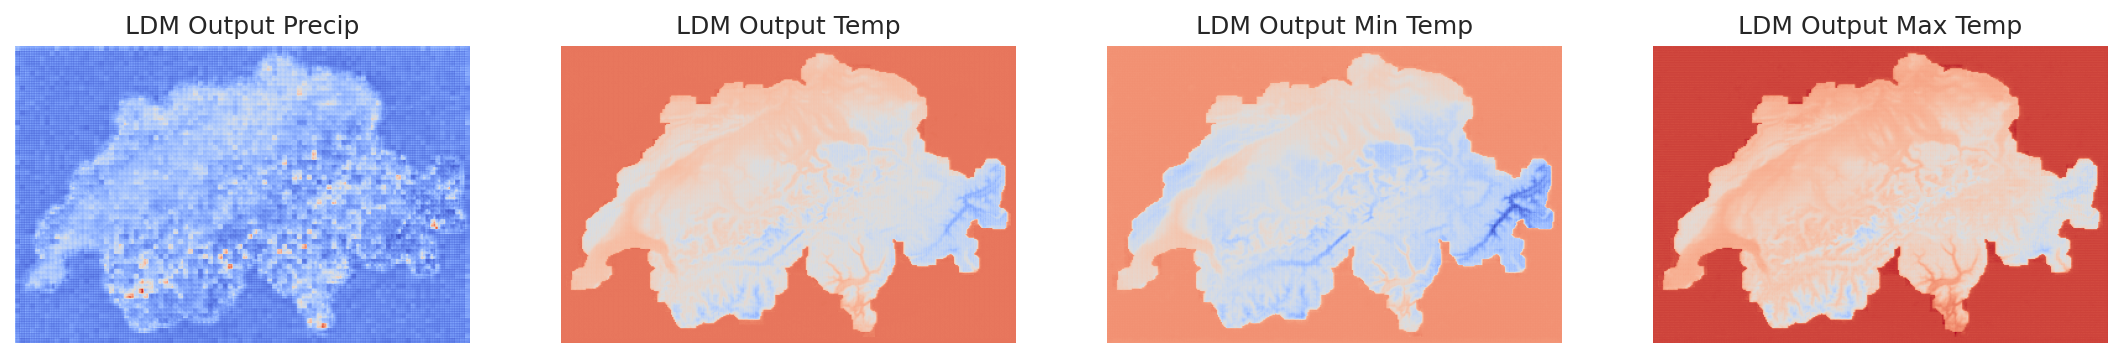

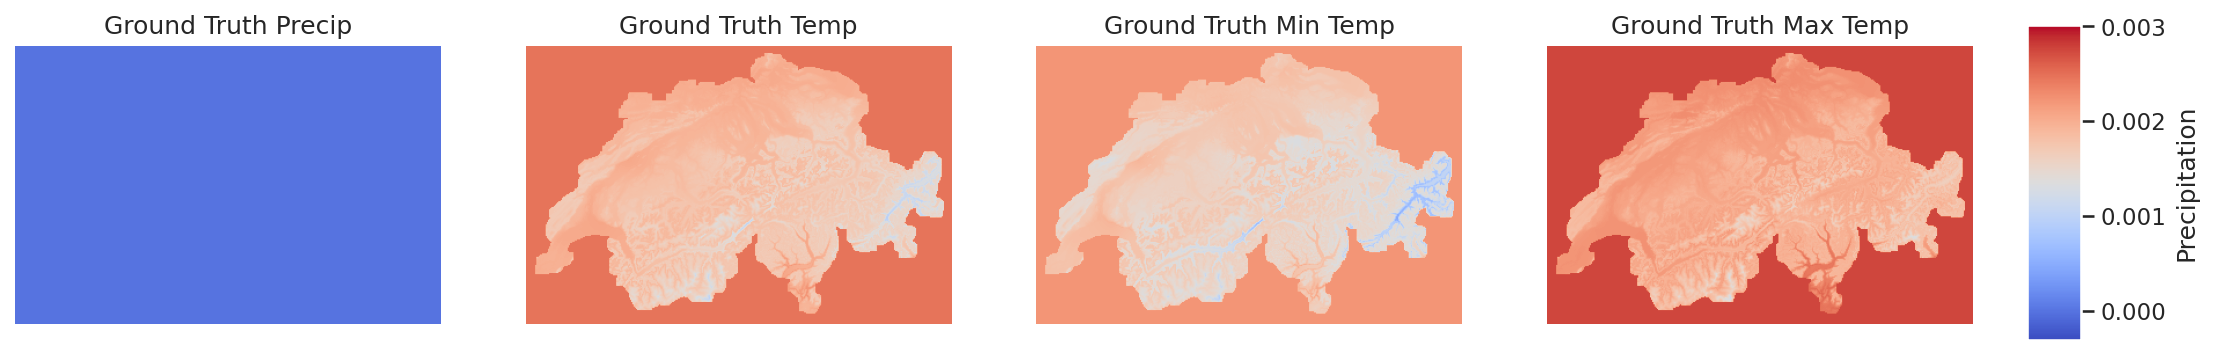

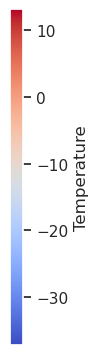

In [353]:
channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]

fig, axes = plt.subplots(1, 4, figsize=(18, 3), dpi=150)

precip_vmin = min(final_pred_denorm_c[0].min(), target_denorm_c[0].min())
precip_vmax = max(final_pred_denorm_c[0].max(), target_denorm_c[0].max())
temp_vmin = min(final_pred_denorm_c[1:].min(), target_denorm_c[1:].min())
temp_vmax = max(final_pred_denorm_c[1:].max(), target_denorm_c[1:].max())

im_precip = None
im_temp = None

for j in range(4):
    # LDM/Final prediction
    im = axes[j].imshow(np.flipud(final_pred_denorm_c[j]),
                        cmap='coolwarm',
                        vmin=precip_vmin if j == 0 else temp_vmin,
                        vmax=precip_vmax if j == 0 else temp_vmax)
    axes[j].set_title(f"LDM Output {channel_names[j]}")
    axes[j].axis('off')
    if j == 0:
        im_precip = im
    else:
        im_temp = im

plt.figure(figsize=(18, 3), dpi=150)
axes_gt = []
for j in range(4):
    ax = plt.subplot(1, 4, j+1)
    axes_gt.append(ax)
    im = ax.imshow(np.flipud(target_denorm_c[j]),
                   cmap='coolwarm',
                   vmin=precip_vmin if j == 0 else temp_vmin,
                   vmax=precip_vmax if j == 0 else temp_vmax)
    ax.set_title(f"Ground Truth {channel_names[j]}")
    ax.axis('off')
    if j == 0:
        im_precip_gt = im
    else:
        im_temp_gt = im

plt.subplots_adjust(right=0.85)
cbar_ax = plt.gcf().add_axes([0.87, 0.15, 0.02, 0.7])
plt.colorbar(im_precip, cax=cbar_ax, label="Precipitation", shrink=0.6)
plt.show()

plt.subplots_adjust(right=0.85)
cbar_ax = plt.gcf().add_axes([0.87, 0.15, 0.02, 0.7])
plt.colorbar(im_temp, cax=cbar_ax, label="Temperature", shrink=0.6)
plt.show()
